### Задача - классификатор текста
вход - текст 

выход - одно значение

Many-to-one 


In [86]:
tf.__version__

'2.3.3'

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

import nltk
nltk.download('stopwords')
nltk.download('wordnet')
lemma = nltk.wordnet.WordNetLemmatizer()
import string
import pymorphy2
morph = pymorphy2.MorphAnalyzer()

import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
#from keras.wrappers.scikit_learn import KerasClassifier

import os
import pathlib
from pathlib import Path

from collections import Counter

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\София\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\София\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## 1. Загрузка данных

In [29]:
# загружаем файл тестовых данных
read_file_path = 'test_data_solution.txt'
a = []
with open(read_file_path, 'r', encoding="utf-8") as file:
    for line in file:
        a.append(line)

In [30]:
# загружаем файл тренировочных данных
read_file_path = 'train_data.txt'
b = []
with open(read_file_path, 'r', encoding="utf-8") as file:
    for line in file:
        b.append(line)

*Description*

Train data:\
ID ::: TITLE ::: GENRE ::: DESCRIPTION\
ID ::: TITLE ::: GENRE ::: DESCRIPTION\
ID ::: TITLE ::: GENRE ::: DESCRIPTION\
ID ::: TITLE ::: GENRE ::: DESCRIPTION

Test data:\
ID ::: TITLE ::: DESCRIPTION\
ID ::: TITLE ::: DESCRIPTION\
ID ::: TITLE ::: DESCRIPTION\
ID ::: TITLE ::: DESCRIPTION

In [31]:
def genre_descr(abc):
# извлекаем жанр и описание
    genre = []
    descr = []
    for a_ in abc:
        start1 = a_.find(':')
        if a_[start1 + 1] == ':' and a_[start1 + 2] == ':':
            a_ = ''.join([a_[i] for i in range(len(a_)) if i != start1 and i != start1 + 1 and i != start1 + 2]) # удаление первых :::
            while True:
                start2 = a_.find(':')
                if a_[start2 + 1] != ':':
                    a_ = a_.replace(a_[start2], '', 1) # удаление : внутри названия
                else:
                    break            
            start2 = a_.find(':')    
            if a_[start2 + 1] == ':' and a_[start2 + 2] == ':':
                a_ = a_.replace(a_[: start2], '')  # удаление слов до первых :::
                start1 = a_.find(':')
                if a_[start1 + 1] == ':' and a_[start1 + 2] == ':':
                    a_ = ''.join([a_[i] for i in range(len(a_)) if i != start1 and i != start1 + 1 and i != start1 + 2 and i != start1 + 3]) # удаление вторых :::
                    genre.append(a_[: a_.find(':') - 1]) # жанр
                    descr.append(a_[a_.find(':') + 4 :-1]) # описание
    return genre, descr
    

In [32]:
genre_test, descr_test = genre_descr(a)
genre_train, descr_train = genre_descr(b)
len(genre_train), len(genre_test)

In [34]:
Counter(genre_test).most_common(), Counter(genre_train).most_common()

([('drama', 13611),
  ('documentary', 13096),
  ('comedy', 7446),
  ('short', 5072),
  ('horror', 2204),
  ('thriller', 1590),
  ('action', 1314),
  ('western', 1032),
  ('reality-tv', 883),
  ('family', 783),
  ('adventure', 775),
  ('music', 731),
  ('romance', 672),
  ('sci-fi', 646),
  ('adult', 590),
  ('crime', 505),
  ('animation', 498),
  ('sport', 431),
  ('talk-show', 391),
  ('fantasy', 322),
  ('mystery', 318),
  ('musical', 276),
  ('biography', 264),
  ('history', 243),
  ('game-show', 193),
  ('news', 181),
  ('war', 132)],
 [('drama', 13613),
  ('documentary', 13096),
  ('comedy', 7447),
  ('short', 5072),
  ('horror', 2204),
  ('thriller', 1591),
  ('action', 1315),
  ('western', 1032),
  ('reality-tv', 884),
  ('family', 784),
  ('adventure', 775),
  ('music', 731),
  ('romance', 672),
  ('sci-fi', 647),
  ('adult', 590),
  ('crime', 505),
  ('animation', 498),
  ('sport', 432),
  ('talk-show', 391),
  ('fantasy', 323),
  ('mystery', 319),
  ('musical', 277),
  ('biog

In [35]:
# df1 - таблица с тренировочными данными
# df2 - таблица с тестовыми данными

df1 = pd.DataFrame( 
columns=['descr_train', 'genre_train'])
df1.genre_train = genre_train
df1.descr_train = descr_train

df2 = pd.DataFrame( 
columns=['descr_test', 'genre_test'])
df2.genre_test = genre_test
df2.descr_test = descr_test

In [36]:
df1.head()

,descr_train,genre_train
0,Listening in to a conversation between his doc...,drama
1,A brother and sister with a past incestuous re...,thriller
2,As the bus empties the students for their fiel...,adult
3,To help their unemployed father make ends meet...,drama
4,The film's title refers not only to the un-rec...,drama


In [37]:
df2.head()

,descr_test,genre_test
0,"L.R. Brane loves his life - his car, his apart...",thriller
1,"Spain, March 1964: Quico is a very naughty chi...",comedy
2,One year in the life of Albin and his family o...,documentary
3,"His father has died, he hasn't spoken with his...",drama
4,Before he was known internationally as a marti...,drama


## 2. Предварительная обработка текста

### 2.1 Токенизация по словам

In [38]:
stop_words = nltk.corpus.stopwords.words('english') # стоп слова для русского языка
def tokenize_text(raw_text: str):
    """Функция для токенизации текста
    
    :param raw_text: исходная текстовая строка
    """
    res = raw_text
    res = re.compile('[\d]').sub('', res) # удаление всех цифр
    res = re.compile('[^\w\s]').sub('', res) # удаление всех знаков
    res = ''.join(re.findall(r'[\s^a-zA-Z]+|[\d]+|[^\w\s]', res)) #удаляем иностранные буквы
    res = nltk.word_tokenize(res.lower()) # разбиение по словам
    res = [i for i in res if (i not in stop_words )] # удаление стоп-слов
    res = [lemma.lemmatize(word) for word in res] # приведение к нормальной форме для англ. языка 
    return res

In [39]:
tokenized_text1 = [tokenize_text(data) for data in descr_train]
tokenized_text2 = [tokenize_text(data) for data in descr_test]

# # применяем функцию к датафрейму 
# tokenized_text1= df1.descr_train.apply(tokenize_text)

# # применяем функцию к датафрейму 
# tokenized_text2= df2.descr_test.apply(tokenize_text)

In [40]:
# добавляем новую колонку в исходный датафрейм
df1 = df1.assign(
    tokenized_text=tokenized_text1
)

# добавляем новую колонку в исходный датафрейм
df2 = df2.assign(
    tokenized_text=tokenized_text2
)

In [41]:
df1.head()

,descr_train,genre_train,tokenized_text
0,Listening in to a conversation between his doc...,drama,"[listening, conversation, doctor, parent, year..."
1,A brother and sister with a past incestuous re...,thriller,"[brother, sister, past, incestuous, relationsh..."
2,As the bus empties the students for their fiel...,adult,"[bus, empty, student, field, trip, museum, nat..."
3,To help their unemployed father make ends meet...,drama,"[help, unemployed, father, make, end, meet, ed..."
4,The film's title refers not only to the un-rec...,drama,"[film, title, refers, unrecovered, body, groun..."


In [42]:
df2.head()

,descr_test,genre_test,tokenized_text
0,"L.R. Brane loves his life - his car, his apart...",thriller,"[lr, brane, love, life, car, apartment, job, e..."
1,"Spain, March 1964: Quico is a very naughty chi...",comedy,"[spain, march, quico, naughty, child, three, b..."
2,One year in the life of Albin and his family o...,documentary,"[one, year, life, albin, family, shepherd, nor..."
3,"His father has died, he hasn't spoken with his...",drama,"[father, died, hasnt, spoken, brother, year, s..."
4,Before he was known internationally as a marti...,drama,"[known, internationally, martial, art, superst..."


### 2.2 Составление словаря

#### 2.2.1 Метки

In [43]:
df1.genre_train.unique()

array(['drama', 'thriller', 'adult', 'documentary', 'comedy', 'crime',
       'reality-tv', 'horror', 'sport', 'animation', 'action', 'fantasy',
       'short', 'sci-fi', 'music', 'adventure', 'talk-show', 'western',
       'family', 'mystery', 'history', 'news', 'biography', 'romance',
       'game-show', 'musical', 'war'], dtype=object)

In [44]:
# словарь меток
dict_labels = {name : i for (i, name) in enumerate(df1.genre_train.unique())} # слово - цифра
dict_labels_ = {name : i for (i, name) in dict_labels.items()} # цифра - слово

# метки в цифры
def labels_to_num(text):
    text_index = dict_labels[text] 
    return text_index

label_num1 = [labels_to_num(data) for data in genre_train]
label_num2 = [labels_to_num(data) for data in genre_test]

# # применяем функцию к датафрейму 
# label_num= df1.genre_train.apply(labels_to_num)

# # применяем функцию к датафрейму 
# label_num= df2.genre_test.apply(labels_to_num)

In [45]:
# добавляем новую колонку в исходный датафрейм
df1 = df1.assign(
    label_num=label_num1
)

# добавляем новую колонку в исходный датафрейм
df2 = df2.assign(
    label_num=label_num2
)

In [46]:
df1.head()

,descr_train,genre_train,tokenized_text,label_num
0,Listening in to a conversation between his doc...,drama,"[listening, conversation, doctor, parent, year...",0
1,A brother and sister with a past incestuous re...,thriller,"[brother, sister, past, incestuous, relationsh...",1
2,As the bus empties the students for their fiel...,adult,"[bus, empty, student, field, trip, museum, nat...",2
3,To help their unemployed father make ends meet...,drama,"[help, unemployed, father, make, end, meet, ed...",0
4,The film's title refers not only to the un-rec...,drama,"[film, title, refers, unrecovered, body, groun...",0


#### 2.2.2 Признаки

In [47]:
# Словарь из всех встречающихся слов
a = []
for i in range(df1.shape[0]):
    a += df1.tokenized_text[i]
b = []
for i in range(df2.shape[0]):
    b += df2.tokenized_text[i]
c = a + b

# удаляем слова длиной меньше 3 символов
c_ = [word for word in c if (len(word) > 3)]
len(c), len(c_)

(6163007, 5590978)

In [48]:
dict_un = list(dict(Counter(c_)).keys())
len(dict_un)

202563

In [49]:
# оставляем слова, которые встречаются более n_c раз
c_un = dict_un
n_c = 100 # 0 - если оставляем все слова
count = dict(Counter(c_))
c_un_ = []
for word in c_un:
    if count[word] > n_c:
        c_un_.append(word)
len(c_un), len(c_un_)

(202563, 6846)

In [50]:
dict_text = {name : i for (i, name) in enumerate(c_un_)}
dict_text["<UNKNOWN>"] = len(dict_text) # если встретится слово не из словаря
dict_text["<PAD>"] = len(dict_text) # для паддинга
#dict_text

In [51]:
len(c_un_), len(dict_text)

(6846, 6848)

### 2.3 Токенизация по индексам

In [52]:
def text_to_index(text):
    text_index = [dict_text.get(word, dict_text['<UNKNOWN>']) for word in text if word in dict_text] #[dict_text[word] for word in text]
    return text_index

In [53]:
# текст в последовательность индексов
def text_to_index(text):
    text_index = [dict_text.get(word, dict_text['<UNKNOWN>']) for word in text] #[dict_text[word] for word in text]
    return text_index

tokenized_text_index1 = [text_to_index(data) for data in tokenized_text1]
tokenized_text_index2 = [text_to_index(data) for data in tokenized_text2]

# # применяем функцию к датафрейму 
# tokenized_text_index= df1.tokenized_text.apply(text_to_index)

# # применяем функцию к датафрейму 
# tokenized_text_index= df2.tokenized_text.apply(text_to_index)

In [54]:
# добавляем новую колонку в исходный датафрейм
df1 = df1.assign(
    tokenized_text_index=tokenized_text_index1
)

# добавляем новую колонку в исходный датафрейм
df2 = df2.assign(
    tokenized_text_index=tokenized_text_index2
)

In [55]:
df1.head()

,descr_train,genre_train,tokenized_text,label_num,tokenized_text_index
0,Listening in to a conversation between his doc...,drama,"[listening, conversation, doctor, parent, year...",0,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
1,A brother and sister with a past incestuous re...,thriller,"[brother, sister, past, incestuous, relationsh...",1,"[39, 40, 41, 6846, 42, 43, 44, 42, 45, 46, 47,..."
2,As the bus empties the students for their fiel...,adult,"[bus, empty, student, field, trip, museum, nat...",2,"[6846, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58,..."
3,To help their unemployed father make ends meet...,drama,"[help, unemployed, father, make, end, meet, ed...",0,"[86, 87, 88, 89, 6846, 20, 90, 91, 40, 92, 93,..."
4,The film's title refers not only to the un-rec...,drama,"[film, title, refers, unrecovered, body, groun...",0,"[63, 139, 140, 6846, 131, 141, 142, 143, 144, ..."


In [56]:
df2.head()

,descr_test,genre_test,tokenized_text,label_num,tokenized_text_index
0,"L.R. Brane loves his life - his car, his apart...",thriller,"[lr, brane, love, life, car, apartment, job, e...",1,"[6846, 6846, 31, 30, 6846, 267, 6846, 812, 907..."
1,"Spain, March 1964: Quico is a very naughty chi...",comedy,"[spain, march, quico, naughty, child, three, b...",4,"[826, 4013, 6846, 6431, 410, 395, 3665, 1107, ..."
2,One year in the life of Albin and his family o...,documentary,"[one, year, life, albin, family, shepherd, nor...",3,"[6846, 216, 30, 6846, 104, 5259, 893, 6846, 37..."
3,"His father has died, he hasn't spoken with his...",drama,"[father, died, hasnt, spoken, brother, year, s...",0,"[88, 1271, 6600, 1544, 39, 216, 2981, 357, 420..."
4,Before he was known internationally as a marti...,drama,"[known, internationally, martial, art, superst...",0,"[558, 1946, 1586, 6846, 3950, 1617, 6846, 2649..."


### 2.4 Паддинг

In [57]:
max([len(a) for a in tokenized_text_index1]), np.mean([len(a) for a in tokenized_text_index1]), np.median([len(a) for a in tokenized_text_index1])

(1416, 56.85151163005183, 44.0)

In [58]:
max([len(a) for a in tokenized_text_index2]), np.mean([len(a) for a in tokenized_text_index2]), np.median([len(a) for a in tokenized_text_index2])

(784, 56.84451742652078, 44.0)

In [59]:
# Приведение всех цепочек в датасете к одной длине с помощью паддинга
MAX_SEQ_LEN1 = max([len(a) for a in tokenized_text_index1]) # максимальная длина последовательности
MAX_SEQ_LEN2 = max([len(a) for a in tokenized_text_index2]) # максимальная длина последовательности
MAX_SEQ_LEN = max(MAX_SEQ_LEN1, MAX_SEQ_LEN2)

MAX_SEQ_LEN = 64

tokenized_text_index_len1 = tf.keras.preprocessing.sequence.pad_sequences(
    tokenized_text_index1,
    value=dict_text["<PAD>"],
    padding='post',
    maxlen=MAX_SEQ_LEN)


tokenized_text_index_len2 = tf.keras.preprocessing.sequence.pad_sequences(
tokenized_text_index2,
value=dict_text["<PAD>"],
padding='post',
maxlen=MAX_SEQ_LEN)

In [60]:
# добавляем новую колонку в исходный датафрейм
# for i in range(len(tokenized_text_index_len1)):
#     df1.loc[i, 'tokenized_text_index_len'] = str(tokenized_text_index_len1[i])

# # добавляем новую колонку в исходный датафрейм
# for i in range(len(tokenized_text_index_len2)):
#     df2.loc[i, 'tokenized_text_index_len'] = str(tokenized_text_index_len2[i])    

In [61]:
df1.head()

,descr_train,genre_train,tokenized_text,label_num,tokenized_text_index
0,Listening in to a conversation between his doc...,drama,"[listening, conversation, doctor, parent, year...",0,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
1,A brother and sister with a past incestuous re...,thriller,"[brother, sister, past, incestuous, relationsh...",1,"[39, 40, 41, 6846, 42, 43, 44, 42, 45, 46, 47,..."
2,As the bus empties the students for their fiel...,adult,"[bus, empty, student, field, trip, museum, nat...",2,"[6846, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58,..."
3,To help their unemployed father make ends meet...,drama,"[help, unemployed, father, make, end, meet, ed...",0,"[86, 87, 88, 89, 6846, 20, 90, 91, 40, 92, 93,..."
4,The film's title refers not only to the un-rec...,drama,"[film, title, refers, unrecovered, body, groun...",0,"[63, 139, 140, 6846, 131, 141, 142, 143, 144, ..."


In [62]:
tokenized_text_index_len1[0]

array([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,   10,
         11,   12,   13,   14,   15,   16, 6846,   17,   18,   19,   20,
         21, 6846,   22,   23,   17, 6846, 6846,   24,   25,   26,   27,
       6846,   28,   29,    5,   11,   30,   31,   32,   33,   34, 6846,
       6846, 6846, 6846,   35,   36,   37,   38, 6847, 6847, 6847, 6847,
       6847, 6847, 6847, 6847, 6847, 6847, 6847, 6847, 6847])

In [63]:
Counter(tokenized_text_index_len1[0]).most_common(10)

[(6847, 13),
 (6846, 9),
 (5, 2),
 (11, 2),
 (17, 2),
 (0, 1),
 (1, 1),
 (2, 1),
 (3, 1),
 (4, 1)]

### 2.2 - 2.4 Автоматически через бибилиотеку

#### как в словаре оставлять слова, которые повторяются более n раз?

In [64]:
tokenized_text1_ = []
for text in tokenized_text1:
    tokenized_text1_.append(' '.join(text))
tokenized_text2_ = []
for text in tokenized_text2:
    tokenized_text2_.append(' '.join(text))

In [65]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(oov_token=1) #oov_token=1 - если слово не встретилось, 0 - для падинга
tokenizer.fit_on_texts(tokenized_text1_ + tokenized_text2_)
len(tokenizer.word_index)

206926

In [66]:
MAX_SEQ_LEN = 64
tokenized_text_index_train = tokenizer.texts_to_sequences(tokenized_text1)
tokenized_text_index_test = tokenizer.texts_to_sequences(tokenized_text2)
tokenized_text_index_len_train = tf.keras.preprocessing.sequence.pad_sequences(tokenized_text_index_train, padding='post', maxlen=MAX_SEQ_LEN)
tokenized_text_index_len_test = tf.keras.preprocessing.sequence.pad_sequences(tokenized_text_index_test, padding='post', maxlen=MAX_SEQ_LEN)

In [67]:
tokenized_text_index_len_train[0]

array([ 4254,  1075,   298,   135,   445,  2596,   370,  1903,  1237,
          63,   355,    58,  4506,   628,  1229,   823,  1660, 46097,
        1149,   454,  4583,    38,   470,  7406,   724,   877,  1149,
         729,  9795,   116,   503,  5230,  1629,  2945,  2391,  1666,
        2596,    58,     2,    11,   352,   207,    18,  1207, 10337,
       11826, 11498,   395,  2141,  6813,   887,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0])

In [68]:
Counter(tokenized_text_index_len_train[0]).most_common(10)

[(0, 13),
 (2596, 2),
 (58, 2),
 (1149, 2),
 (4254, 1),
 (1075, 1),
 (298, 1),
 (135, 1),
 (445, 1),
 (370, 1)]

### 2.5 Bag of words

#### 2.5.1 Вручную

In [69]:
num_ob = np.array(tokenized_text_index1).shape[0] # количество объектов
VOCAB_SIZE = len(dict_text) # размер словаря
num_ob, VOCAB_SIZE

C:\Users\881F~1\AppData\Local\Temp/ipykernel_11004/139926362.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  num_ob = np.array(tokenized_text_index1).shape[0] # количество объектов


(54213, 6848)

In [70]:
tok_train = np.array([np.array([tokenized_text_index1_1.count(a) for tokenized_text_index1_1 in tokenized_text_index1]) for a in range(0, VOCAB_SIZE)])

KeyboardInterrupt: 

In [ ]:
tok_train = tok_train.T
tok_train.shape

In [ ]:
dict(Counter(tok_train[0]))

In [ ]:
# проверка
import random
k = random.randint(0, tok_train.shape[0])

len(tokenized_text_index1[k]) == sum(tok_train[k])

In [ ]:
tok_test = np.array([np.array([tokenized_text_index2_1.count(a) for tokenized_text_index2_1 in tokenized_text_index2]) for a in range(0, VOCAB_SIZE)])

In [ ]:
tok_test = tok_test.T
tok_test.shape

#### 2.5.2 Автоматически через библиотеку

In [71]:
from sklearn.feature_extraction.text import CountVectorizer

In [72]:
vectorizer = CountVectorizer(vocabulary=dict_text) #vocabulary=dict_text
document_matrix = vectorizer.fit_transform(tokenized_text1_)
# результат - матрица, в которой находятся числа, строк в мастрице столько, сколько документов
# а столбцов столько, сколько токенов
document_matrix

<54213x6848 sparse matrix of type '<class 'numpy.int64'>'
	with 1959885 stored elements in Compressed Sparse Row format>

In [73]:
tok_train_ = document_matrix.toarray()

In [74]:
tok_train_.shape

(54213, 6848)

In [75]:
dict(Counter(tok_train_[0]))

{1: 36, 2: 3, 0: 6809}

In [76]:
document_matrix = vectorizer.fit_transform(tokenized_text2_)
# результат - матрица, в которой находятся числа, строк в мастрице столько, сколько документов
# а столбцов столько, сколько токенов
document_matrix

<54199x6848 sparse matrix of type '<class 'numpy.int64'>'
	with 1964017 stored elements in Compressed Sparse Row format>

In [77]:
tok_test_ = document_matrix.toarray()

### 2.6 Word2Vec

In [ ]:
from gensim.models import Word2Vec

In [ ]:
w2v = Word2Vec(sentences=tokenized_text1 + tokenized_text2, vector_size=16, min_count=1, epochs=10)
embedding_matrix_w2v = np.random.random((len(dict_text) + 1, w2v.vector_size))

In [ ]:
for word in dict_text.keys(): #tokenizer.word_index.items()
    i = dict_text[word]
    try:
        embedding_matrix_w2v[i] = w2v.wv[word]
    except:
        print(word)

### 2.7 FastText

In [ ]:
from gensim.models import FastText

In [ ]:
ft = FastText(sentences=tokenized_text1 + tokenized_text2, vector_size=16, min_count=1, epochs=10)
embedding_matrix_ft = np.random.random((len(dict_text) + 1, ft.vector_size))

In [ ]:
for word in dict_text.keys(): #tokenizer.word_index.items()
    i = dict_text[word]
    try:
        embedding_matrix_ft[i] = ft.wv[word]
    except:
        print(word)

## 3. Создание модели

In [78]:
x_train = tokenized_text_index_len1
x_test = tokenized_text_index_len2
y_train = np.array(label_num1)
y_test = np.array(label_num2)

In [ ]:
with open('./data1.pickle', 'wb') as f :
    pickle.dump([x_train, x_test, y_train, y_test], f)

with open('./data2.pickle', 'wb') as f :
    pickle.dump([tok_train_, tok_test_], f)

with open('./dict.pickle', 'wb') as f :
    pickle.dump([embedding_matrix_w2v, embedding_matrix_ft, len(dict_text)], f)

In [ ]:
with open('./data1.pickle', 'rb') as f :
    x_train, x_test, y_train, y_test = pickle.load(f)

with open('./data2.pickle', 'rb') as f :
    tok_train_, tok_test_ = pickle.load(f)

with open('./dict.pickle', 'rb') as f :
    embedding_matrix_w2v, embedding_matrix_ft, len_dict = pickle.load(f)

In [ ]:
x_train.shape, x_test.shape

In [80]:
# ПАРАМЕТРЫ МОДЕЛИ
VOCAB_SIZE = len(dict_text) # Количество слов в словаре
EMB_SIZE = 16 # (16) Размер векторного представления (эмбеддинга) - можно оптимизировать 
N = len(np.unique(y_train)) # количество классов
NEURONS = 16 # (16) количество нейронов на выходе предпоследнего слоя - можно оптимизировать

# ПАРАМЕТРЫ ПРИ ОБУЧЕНИИ
BATCH_SIZE = 1024 # (32) размер батча (кол-во прошедших объектов через модель за одну итерацию внутри одной эпохи) - можно оптимизировать (раз в 50 меньше кол-ва объектов)
NUM_EPOCHS = 100 # (100) количество эпох (столько шагов градиетного спуска - обновление весов) - можно оптимизировать
LEARNING_RATE = 0.005 # (0.005) скорость обучения - можно оптимизировать
# количество итераций внутри одной эпохи = число батчей = кол-во объектов / BATCH_SIZE

### 3.1 Обычная сеть прямого распространения

#### 3.1.1 Через эмбеддинг

In [81]:
# сохранение модели
dir_path = pathlib.Path.home()
cpt_filename = "best_checkpoint_1_1.hdf5"  
cpt_path =str(dir_path / cpt_filename)

In [82]:
# сохранение модели
#cpt_path = "best_checkpoint_1_1.hdf5" 

if os.path.isfile(cpt_path): # удаление файла, если есть
    os.remove(cpt_path)
        
checkpoint = tf.keras.callbacks.ModelCheckpoint(cpt_path, monitor='val_sparse_categorical_accuracy', verbose=1, save_best_only=True, mode='max')

# определение модели    
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(VOCAB_SIZE + 1, EMB_SIZE),
    tf.keras.layers.GlobalAveragePooling1D(),
#    tf.keras.layers.Dropout(0.9),
    tf.keras.layers.Dense(NEURONS, activation=tf.nn.relu),
    tf.keras.layers.Dense(N, activation=tf.nn.softmax), # выходной слой (27 - кол-во предсказанных вероятностей на выходе)
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          109584    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                272       
_________________________________________________________________
dense_1 (Dense)              (None, 27)                459       
Total params: 110,315
Trainable params: 110,315
Non-trainable params: 0
_________________________________________________________________


In [83]:
# определение оптимизатора
optimizer = tf.keras.optimizers.RMSprop(learning_rate=LEARNING_RATE) 
#optimizer = tf.keras.optimizers.Adam()
# определение функционала ошибки
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)

# сборка модели
model.compile(optimizer=optimizer, loss=loss, metrics=["sparse_categorical_accuracy"]) 

# обучение модели
history_1 = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=NUM_EPOCHS, verbose=1, batch_size=BATCH_SIZE, shuffle=True, callbacks=[checkpoint])

Epoch 1/100
52/53 [============================>.] - ETA: 0s - loss: 2.5017 - sparse_categorical_accuracy: 0.2765
Epoch 00001: val_sparse_categorical_accuracy improved from -inf to 0.40748, saving model to C:\Users\София\best_checkpoint_1_1.hdf5
53/53 [==============================] - 2s 35ms/step - loss: 2.4975 - sparse_categorical_accuracy: 0.2792 - val_loss: 2.2519 - val_sparse_categorical_accuracy: 0.4075
Epoch 2/100
53/53 [==============================] - ETA: 0s - loss: 2.1109 - sparse_categorical_accuracy: 0.4235
Epoch 00002: val_sparse_categorical_accuracy improved from 0.40748 to 0.43416, saving model to C:\Users\София\best_checkpoint_1_1.hdf5
53/53 [==============================] - 1s 24ms/step - loss: 2.1109 - sparse_categorical_accuracy: 0.4235 - val_loss: 1.9742 - val_sparse_categorical_accuracy: 0.4342
Epoch 3/100
51/53 [===========================>..] - ETA: 0s - loss: 1.8721 - sparse_categorical_accuracy: 0.4557- ETA: 0s - loss: 1.9088 - sparse_categorical_accuracy: 

In [84]:
# модель сохранена в
cpt_path

'C:\\Users\\София\\best_checkpoint_1_1.hdf5'

In [ ]:
# загрузка модели
restored_model_1 = tf.keras.models.load_model(cpt_path)
results_1_1 = restored_model_1.evaluate(x_test, y_test)
print('Test loss: {:.4f}'.format(results_1_1[0]))
print('Test accuracy: {:.2f} %'.format(results_1_1[1]*100))

In [ ]:
results = model.evaluate(x_test, y_test)
print('Test loss: {:.4f}'.format(results[0]))
print('Test accuracy: {:.2f} %'.format(results[1]*100))

In [87]:
def plots(history_):
    #Графики лосса и точности на обучающем и валидационном датасетах
    epochs = range(1, len(history_.history['sparse_categorical_accuracy']) + 1)

    plt.figure()
    plt.plot(epochs, history_.history['loss'], 'bo', label='Training loss')
    plt.plot(epochs, history_.history['val_loss'], 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()

    plt.figure()
    plt.plot(epochs, history_.history['sparse_categorical_accuracy'], 'bo', label='Training acc')
    plt.plot(epochs, history_.history['val_sparse_categorical_accuracy'], 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()

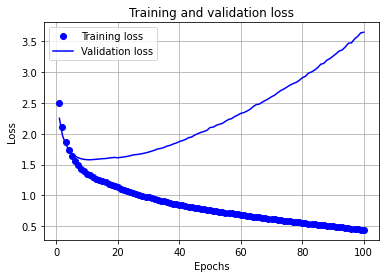

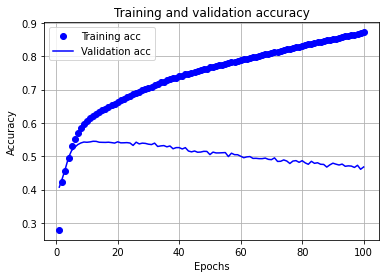

In [88]:
plots(history_1)

In [90]:
import random

In [92]:
i = random.randint(0, x_test.shape[0])
text_encoded = x_test[i]
print(dict_labels_[model.predict_classes(np.array(text_encoded)[None, :])[0]])
print(dict_labels_[y_test[i]])

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
documentary
documentary


In [93]:
# вероятности
model.predict(np.array(text_encoded)[None, :])

array([[2.1762202e-02, 1.3328958e-04, 2.7748829e-11, 8.4338278e-01,
        4.3305956e-02, 3.1537173e-04, 6.4741466e-03, 2.2206683e-13,
        3.3226158e-10, 6.0780213e-04, 2.1215632e-05, 2.6278809e-05,
        6.2018111e-02, 1.3984082e-05, 1.9394052e-12, 2.3891784e-03,
        2.7982131e-05, 9.5692552e-16, 3.8807685e-03, 5.8258286e-07,
        2.5050379e-03, 8.7987230e-04, 3.7912212e-03, 6.1327937e-06,
        3.7282382e-09, 8.3311384e-08, 8.4579429e-03]], dtype=float32)

In [94]:
model.predict(np.array(text_encoded)[None, :]).sum() # сумма вероятностей по классам = 1

0.99999994

#### 3.1.2 Через bag of words

In [ ]:
# сохранение модели
dir_path = pathlib.Path.home()
cpt_filename = "best_checkpoint_1_2.hdf5"  
cpt_path =str(dir_path / cpt_filename)

In [ ]:
# сохранение модели
#cpt_path = "best_checkpoint_1_2.hdf5"

if os.path.isfile(cpt_path): # удаление файла, если есть
    os.remove(cpt_path)
        
checkpoint = tf.keras.callbacks.ModelCheckpoint(cpt_path, monitor='val_sparse_categorical_accuracy', verbose=1, save_best_only=True, mode='max')

# определение модели    
model = tf.keras.Sequential([
    tf.keras.layers.Dense(NEURONS, input_shape=(VOCAB_SIZE, ), activation=tf.nn.relu),
    tf.keras.layers.Dense(N, activation=tf.nn.softmax), # выходной слой (27 - кол-во предсказанных вероятностей на выходе)
])

model.summary()

In [ ]:
# определение оптимизатора
optimizer = tf.keras.optimizers.RMSprop(learning_rate=LEARNING_RATE) 
#optimizer = tf.keras.optimizers.Adam()
# определение функционала ошибки
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)

# сборка модели
model.compile(optimizer=optimizer, loss=loss, metrics=["sparse_categorical_accuracy"]) 

# обучение модели
history_1 = model.fit(tok_train_, y_train, validation_data=(tok_test_, y_test), epochs=NUM_EPOCHS, verbose=1, batch_size=BATCH_SIZE, shuffle=True, callbacks=[checkpoint])

In [ ]:
# загрузка модели
restored_model_1 = tf.keras.models.load_model(cpt_path)
results_1_2 = restored_model_1.evaluate(tok_test, y_test)
print('Test loss: {:.4f}'.format(results_1_2[0]))
print('Test accuracy: {:.2f} %'.format(results_1_2[1]*100))

In [ ]:
results = model.evaluate(tok_test, y_test)
print('Test loss: {:.4f}'.format(results[0]))
print('Test accuracy: {:.2f} %'.format(results[1]*100))

In [ ]:
plots(history_1)

#### 3.1.3 Обычная сеть прямого распространения с оптимизацией

##### 3.1.3.1 Через эмбеддинг

In [ ]:
def DL_Model(activation, neurons, emb_size):
    # определение модели    
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(VOCAB_SIZE + 1, EMB_SIZE),
        tf.keras.layers.GlobalAveragePooling1D(),
        tf.keras.layers.Dense(neurons, activation=activation),
        tf.keras.layers.Dense(N, activation=tf.nn.softmax), # выходной слой (8 - кол-во предсказанных вероятностей на выходе)
        ])
    optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE) 
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
    model.compile(optimizer=optimizer, loss=loss, metrics=["accuracy"]) 
    return model

In [ ]:
num_epochs = 20 # количество эпох

emb_size = np.array([10, 20, 30]) # Размер векторного представления
batches = 4096 # размер батча
activation = ['tanh', 'relu', 'linear'] #'softmax', 'relu', 'tanh', 'sigmoid', 'linear' # функция активации
neurons = [10, 20, 30] # количество нейронов на выходе предпоследнего слоя
#optimizer = ['SGD', 'Adam'] #'SGD', 'Adam', 'Adamax' (как зафиксировать learning_rate?) # оптимизатор
param_grid = dict(activation = activation, neurons = neurons, emb_size = emb_size)

In [ ]:
clf = KerasClassifier(build_fn=DL_Model, epochs=num_epochs, verbose=1, shuffle=True, batch_size=batches)
model = GridSearchCV(estimator= clf, param_grid=param_grid)
#model.fit(x_train, y_train) # долго считает, лучшие параметры ниже
#print(model.best_params_) # лучшие параметры
#model.best_score_

In [ ]:
#{'activation': 'tanh', 'emb_size': 10, 'neurons': 20}

### 3.2 Рекуррентная сеть через LSTM

#### 3.2.1 Через эмбеддинг

In [ ]:
# сохранение модели
dir_path = pathlib.Path.home()
cpt_filename = "best_checkpoint_2_1.hdf5"  
cpt_path =str(dir_path / cpt_filename)

In [ ]:
# сохранение модели 
#cpt_path = "best_checkpoint_2_1.hdf5"  

if os.path.isfile(cpt_path): # удаление файла, если есть
    os.remove(cpt_path)
        
checkpoint = tf.keras.callbacks.ModelCheckpoint(cpt_path, monitor='val_sparse_categorical_accuracy', verbose=1, save_best_only=True, mode='max')

# определение модели 
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(VOCAB_SIZE + 1, EMB_SIZE),
    tf.keras.layers.LSTM(NEURONS, return_sequences=False),
    tf.keras.layers.Dense(N, activation=tf.nn.softmax),
])

model.summary()

In [ ]:
# определение оптимизатора
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE) 

# определение функционала ошибки
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)

# сборка модели
model.compile(optimizer=optimizer, loss=loss, metrics=["sparse_categorical_accuracy"]) 

# обучение модели
history_2 = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=NUM_EPOCHS, verbose=1, batch_size=BATCH_SIZE, shuffle=True, callbacks=[checkpoint])

In [ ]:
# загрузка модели
restored_model_2 = tf.keras.models.load_model(cpt_path)
results_2_1 = restored_model_2.evaluate(x_test, y_test)
print('Test loss: {:.4f}'.format(results_2[0]))
print('Test accuracy: {:.2f} %'.format(results_2[1]*100))

In [ ]:
results = model.evaluate(x_test, y_test)
print('Test loss: {:.4f}'.format(results[0]))
print('Test accuracy: {:.2f} %'.format(results[1]*100))

In [ ]:
plots(history_2)

#### 3.2.2 Через Bag of words

In [ ]:
# сохранение модели
dir_path = pathlib.Path.home()
cpt_filename = "best_checkpoint_2_2.hdf5"  
cpt_path =str(dir_path / cpt_filename)

In [ ]:
# сохранение модели  
#cpt_path = "best_checkpoint_2_2.hdf5"

if os.path.isfile(cpt_path): # удаление файла, если есть
    os.remove(cpt_path)
        
checkpoint = tf.keras.callbacks.ModelCheckpoint(cpt_path, monitor='val_sparse_categorical_accuracy', verbose=1, save_best_only=True, mode='max')

# определение модели 
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(VOCAB_SIZE + 1, EMB_SIZE, trainable=False),
    tf.keras.layers.LSTM(NEURONS, return_sequences=False),
    tf.keras.layers.Dense(N, activation=tf.nn.softmax),
])

model.summary()

In [ ]:
# определение оптимизатора
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE) 

# определение функционала ошибки
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)

# сборка модели
model.compile(optimizer=optimizer, loss=loss, metrics=["sparse_categorical_accuracy"]) 

# обучение модели
history_2 = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=NUM_EPOCHS, verbose=1, batch_size=BATCH_SIZE, shuffle=True, callbacks=[checkpoint])

In [ ]:
# загрузка модели
restored_model_2 = tf.keras.models.load_model(cpt_path)
results_2_2 = restored_model_2.evaluate(x_test, y_test)
print('Test loss: {:.4f}'.format(results_2[0]))
print('Test accuracy: {:.2f} %'.format(results_2[1]*100))

In [ ]:
results = model.evaluate(x_test, y_test)
print('Test loss: {:.4f}'.format(results[0]))
print('Test accuracy: {:.2f} %'.format(results[1]*100))

In [ ]:
plots(history_2)

#### 3.2.3 word2vec

In [ ]:
# сохранение модели
dir_path = pathlib.Path.home()
cpt_filename = "best_checkpoint_2_3.hdf5"  
cpt_path =str(dir_path / cpt_filename)

In [ ]:
# сохранение модели 
#cpt_path = "best_checkpoint_2_3.hdf5"

if os.path.isfile(cpt_path): # удаление файла, если есть
    os.remove(cpt_path)
        
checkpoint = tf.keras.callbacks.ModelCheckpoint(cpt_path, monitor='val_sparse_categorical_accuracy', verbose=1, save_best_only=True, mode='max')

# определение модели 
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(VOCAB_SIZE + 1, EMB_SIZE, weights=[embedding_matrix_w2v], trainable=False),
    tf.keras.layers.LSTM(NEURONS, return_sequences=False),
    tf.keras.layers.Dense(N, activation=tf.nn.softmax),
])

model.summary()

In [ ]:
# определение оптимизатора
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE) 

# определение функционала ошибки
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)

# сборка модели
model.compile(optimizer=optimizer, loss=loss, metrics=["sparse_categorical_accuracy"]) 

# обучение модели
history_2 = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=NUM_EPOCHS, verbose=1, batch_size=BATCH_SIZE, shuffle=True, callbacks=[checkpoint])

In [ ]:
# загрузка модели
restored_model_2 = tf.keras.models.load_model(cpt_path)
results_2_3 = restored_model_2.evaluate(x_test, y_test)
print('Test loss: {:.4f}'.format(results_2[0]))
print('Test accuracy: {:.2f} %'.format(results_2[1]*100))

In [ ]:
results = model.evaluate(x_test, y_test)
print('Test loss: {:.4f}'.format(results[0]))
print('Test accuracy: {:.2f} %'.format(results[1]*100))

In [ ]:
plots(history_2)

#### 3.2.4 fasttext

In [ ]:
# сохранение модели
dir_path = pathlib.Path.home()
cpt_filename = "best_checkpoint_2_4.hdf5"  
cpt_path =str(dir_path / cpt_filename)

In [ ]:
# сохранение модели
#cpt_path = "best_checkpoint_2_4.hdf5"  

if os.path.isfile(cpt_path): # удаление файла, если есть
    os.remove(cpt_path)
        
checkpoint = tf.keras.callbacks.ModelCheckpoint(cpt_path, monitor='val_sparse_categorical_accuracy', verbose=1, save_best_only=True, mode='max')

# определение модели 
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(VOCAB_SIZE + 1, EMB_SIZE, weights=[embedding_matrix_ft], trainable=False),
    tf.keras.layers.LSTM(NEURONS, return_sequences=False),
    tf.keras.layers.Dense(N, activation=tf.nn.softmax),
])

model.summary()

In [ ]:
# определение оптимизатора
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE) 

# определение функционала ошибки
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)

# сборка модели
model.compile(optimizer=optimizer, loss=loss, metrics=["sparse_categorical_accuracy"]) 

# обучение модели
history_2 = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=NUM_EPOCHS, verbose=1, batch_size=BATCH_SIZE, shuffle=True, callbacks=[checkpoint])

In [ ]:
# загрузка модели
restored_model_2 = tf.keras.models.load_model(cpt_path)
results_2_4 = restored_model_2.evaluate(x_test, y_test)
print('Test loss: {:.4f}'.format(results_2[0]))
print('Test accuracy: {:.2f} %'.format(results_2[1]*100))

In [ ]:
results = model.evaluate(x_test, y_test)
print('Test loss: {:.4f}'.format(results[0]))
print('Test accuracy: {:.2f} %'.format(results[1]*100))

In [ ]:
plots(history_2)

### 3.3 Рекуррентная сеть через LSTM слой с регуляризацией

#### 3.3.1 Через эмбеддинг

In [ ]:
DROPOUT = 0.5 # можно оптимизировать
RECCURENT_DROPOUT = 0.5 # можно оптимизировать

In [ ]:
# сохранение модели
dir_path = pathlib.Path.home()
cpt_filename = "best_checkpoint_3.hdf5"  
cpt_path =str(dir_path / cpt_filename)

In [ ]:
# сохранение модели 
#cpt_path = "best_checkpoint_3.hdf5"  

if os.path.isfile(cpt_path): # удаление файла, если есть
    os.remove(cpt_path)
        
checkpoint = tf.keras.callbacks.ModelCheckpoint(cpt_path, monitor='val_sparse_categorical_accuracy', verbose=1, save_best_only=True, mode='max')

# определение модели 
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(VOCAB_SIZE + 1, EMB_SIZE),
    tf.keras.layers.LSTM(NEURONS, return_sequences=False, dropout=DROPOUT, recurrent_dropout=RECCURENT_DROPOUT),
    tf.keras.layers.Dense(N, activation=tf.nn.softmax),
])

model.summary()

In [ ]:
# определение оптимизатора
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE) 

# определение функционала ошибки
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)

# сборка модели
model.compile(optimizer=optimizer, loss=loss, metrics=["sparse_categorical_accuracy"]) 

# обучение модели
history_3 = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=NUM_EPOCHS, verbose=1, batch_size=BATCH_SIZE, shuffle=True, callbacks=[checkpoint])

In [ ]:
# загрузка модели
restored_model_3 = tf.keras.models.load_model(cpt_path)
results_3 = restored_model_3.evaluate(x_test, y_test)
print('Test loss: {:.4f}'.format(results_3[0]))
print('Test accuracy: {:.2f} %'.format(results_3[1]*100))

In [ ]:
results = model.evaluate(x_test, y_test)
print('Test loss: {:.4f}'.format(results[0]))
print('Test accuracy: {:.2f} %'.format(results[1]*100))

In [ ]:
plots(history_3)

### 3.4 Рекуррентная сеть с двумя LSTM слоями с регуляризацией

#### 3.4.1 Через эмбеддинг

In [ ]:
# сохранение модели
dir_path = pathlib.Path.home()
cpt_filename = "best_checkpoint_4.hdf5"  
cpt_path =str(dir_path / cpt_filename)

In [ ]:
# сохранение модели
#cpt_path = "best_checkpoint_4.hdf5"  

if os.path.isfile(cpt_path): # удаление файла, если есть
    os.remove(cpt_path)
        
checkpoint = tf.keras.callbacks.ModelCheckpoint(cpt_path, monitor='val_sparse_categorical_accuracy', verbose=1, save_best_only=True, mode='max')

# определение модели 
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(VOCAB_SIZE + 1, EMB_SIZE),
    tf.keras.layers.LSTM(NEURONS, return_sequences=True, dropout=DROPOUT, recurrent_dropout=RECCURENT_DROPOUT),
    tf.keras.layers.LSTM(NEURONS, return_sequences=False, dropout=DROPOUT, recurrent_dropout=RECCURENT_DROPOUT),
    tf.keras.layers.Dense(N, activation=tf.nn.softmax),
])

model.summary()

In [ ]:
# определение оптимизатора
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE) 

# определение функционала ошибки
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)

# сборка модели
model.compile(optimizer=optimizer, loss=loss, metrics=["sparse_categorical_accuracy"]) 

# обучение модели
history_4 = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=NUM_EPOCHS, verbose=1, batch_size=BATCH_SIZE, shuffle=True, callbacks=[checkpoint])

In [ ]:
# загрузка модели
restored_model_4 = tf.keras.models.load_model(cpt_path)
results_4 = restored_model_4.evaluate(x_test, y_test)
print('Test loss: {:.4f}'.format(results_4[0]))
print('Test accuracy: {:.2f} %'.format(results_4[1]*100))

In [ ]:
results = model.evaluate(x_test, y_test)
print('Test loss: {:.4f}'.format(results[0]))
print('Test accuracy: {:.2f} %'.format(results[1]*100))

In [ ]:
plots(history_4)

### 3.5 Двухнаправленная Рекуррентная сеть с двумя LSTM слоями с регуляризацией

#### 3.5.1 Через эмбеддинг

In [ ]:
# сохранение модели
dir_path = pathlib.Path.home()
cpt_filename = "best_checkpoint_5.hdf5"  
cpt_path =str(dir_path / cpt_filename)

In [ ]:
# сохранение модели
#cpt_path = "best_checkpoint_5.hdf5" 

if os.path.isfile(cpt_path): # удаление файла, если есть
    os.remove(cpt_path)
        
checkpoint = tf.keras.callbacks.ModelCheckpoint(cpt_path, monitor='val_sparse_categorical_accuracy', verbose=1, save_best_only=True, mode='max')

# определение модели 
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(VOCAB_SIZE + 1, EMB_SIZE),
    tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(NEURONS, return_sequences=True, dropout=DROPOUT, recurrent_dropout=RECCURENT_DROPOUT)),
    tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(NEURONS, return_sequences=False, dropout=DROPOUT, recurrent_dropout=RECCURENT_DROPOUT)),
    tf.keras.layers.Dense(N, activation=tf.nn.softmax),
])

model.summary()

In [ ]:
# определение оптимизатора
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE) 

# определение функционала ошибки
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)

# сборка модели
model.compile(optimizer=optimizer, loss=loss, metrics=["sparse_categorical_accuracy"]) 

# обучение модели
history_5 = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=NUM_EPOCHS, verbose=1, batch_size=BATCH_SIZE, shuffle=True, callbacks=[checkpoint])

In [ ]:
# загрузка модели
restored_model_5 = tf.keras.models.load_model(cpt_path)
results_5 = restored_model_5.evaluate(x_test, y_test)
print('Test loss: {:.4f}'.format(results_5[0]))
print('Test accuracy: {:.2f} %'.format(results_5[1]*100))

In [ ]:
results = model.evaluate(x_test, y_test)
print('Test loss: {:.4f}'.format(results[0]))
print('Test accuracy: {:.2f} %'.format(results[1]*100))

In [ ]:
plots(history_5)

## 4. Сравнение

In [ ]:
results = [results_1_1[1]*100, results_1_2[1]*100, results_2_1[1]*100, results_2_2[1]*100, results_2_3[1]*100, results_2_4[1]*100, results_3[1]*100, results_4[1]*100, results_5[1]*100]
index = np.arange(len(results))
results

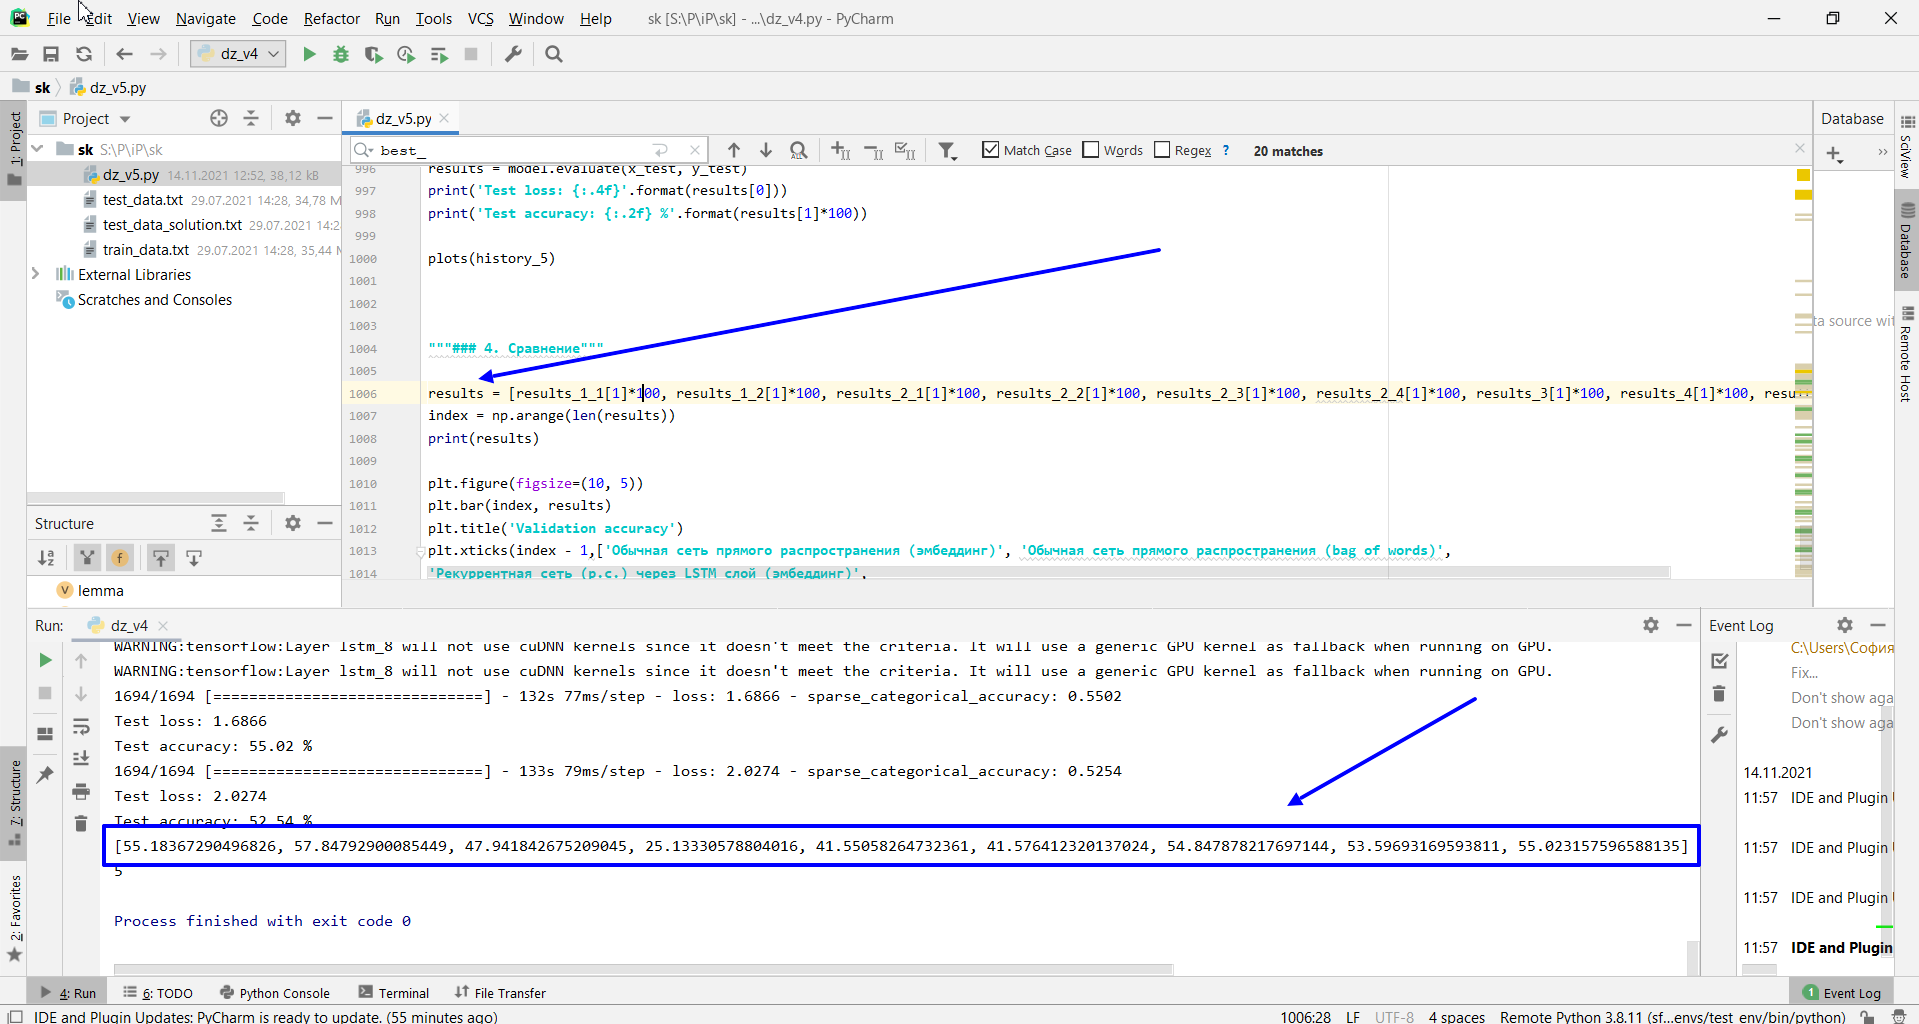

In [22]:
results = [55.18, 57.84, 47.94, 25.13, 41.55, 41.57, 54.84, 53.59, 55.02]
index = np.arange(len(results))
results

[55.18, 57.84, 47.94, 25.13, 41.55, 41.57, 54.84, 53.59, 55.02]

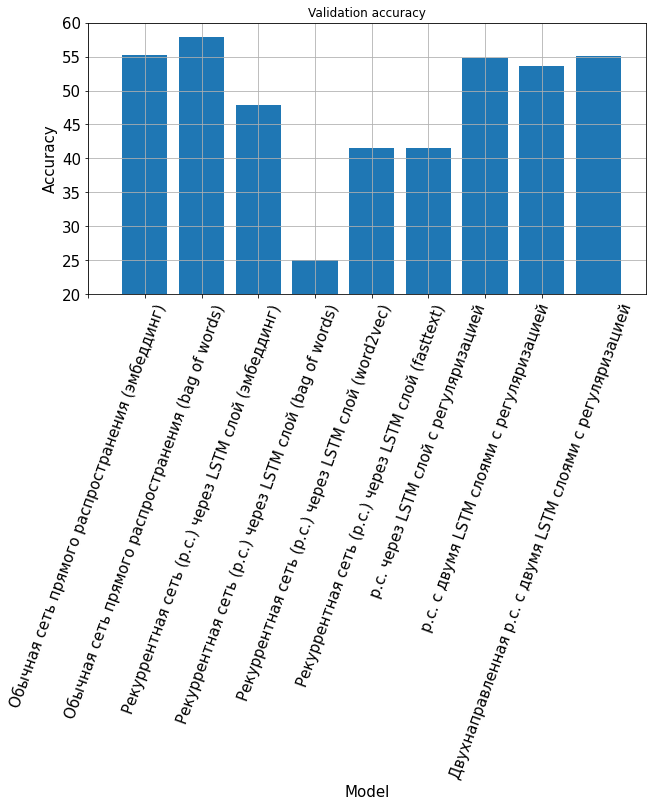

In [24]:
plt.figure(figsize=(10, 5))
plt.bar(index, results)
plt.title('Validation accuracy')
plt.xticks(index - 1,['Обычная сеть прямого распространения (эмбеддинг)', 
                      'Обычная сеть прямого распространения (bag of words)',
'Рекуррентная сеть (р.с.) через LSTM слой (эмбеддинг)',
'Рекуррентная сеть (р.с.) через LSTM слой (bag of words)',
'Рекуррентная сеть (р.с.) через LSTM слой (word2vec)',
'Рекуррентная сеть (р.с.) через LSTM слой (fasttext)',                      
'р.с. через LSTM слой с регуляризацией',
'р.с. с двумя LSTM слоями с регуляризацией',
'Двухнаправленная р.с. с двумя LSTM слоями с регуляризацией'], rotation = 70, fontsize = 15)
plt.yticks(fontsize = 15)
plt.ylim([20, 60])
plt.xlabel('Model', fontsize = 15)
plt.ylabel('Accuracy', fontsize = 15)
plt.grid()